In [94]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

from sklearn import linear_model


## Predictor Variables

In [30]:
# Commodity Prices
dfCommodity = pd.read_csv('../data/commodityPrices.csv')
dfCommodity['date'] = pd.to_datetime(dfCommodity['date'])
dfCommodity = dfCommodity.set_index('date').sort_index()

# Wind Generation
dfWind = pd.read_csv('../data/MISOWindGeneration.csv')
dfWind['date'] = pd.to_datetime(dfWind['date'])
dfWind = dfWind.set_index('date').sort_index()

# Demand
dfLoad = pd.read_csv('../data/MISOActualLoad.csv')
dfLoad['Market Day'] = pd.to_datetime(dfLoad['Market Day'])
dfLoad = dfLoad.set_index('Market Day').sort_index()
dfLoad.index.names = ['date']
dfLoadActual = dfLoad[['Central ActualLoad (MWh)', 'East ActualLoad (MWh)', 'MISO ActualLoad (MWh)', 'Midwest ISO ActualLoad (MWh)', 'North ActualLoad (MWh)', 'South ActualLoad (MWh)', 'West ActualLoad (MWh)']]
dfLoadActual = dfLoadActual.fillna(0)    # Handle NaN

In [32]:
# Merge into a single DataFrame
dfX = pd.merge(dfCommodity, dfWind, left_index=True, right_index=True)
dfX = pd.merge(dfX, dfLoadActual, left_index=True, right_index=True)
dfX.head()

,Central Appalachia,Northern Appalachia,Illinois Basin,Powder River Basin,Uinta Basin,NgPrice,windGenerationMWh,Central ActualLoad (MWh),East ActualLoad (MWh),MISO ActualLoad (MWh),Midwest ISO ActualLoad (MWh),North ActualLoad (MWh),South ActualLoad (MWh),West ActualLoad (MWh)
date,,,,,,,,,,,,,,
2009-07-06,53.333333,51.166667,44,9,44.5,3.355000,325.927083,21654.299167,28127.989583,0,62493.192500,0,0,12710.903750
2009-07-07,53.500000,52.000000,44,9,44.5,3.300000,511.056250,22956.574167,27699.694167,0,63508.234167,0,0,12851.965833
2009-07-08,53.500000,52.000000,44,9,44.5,3.298571,728.637083,22402.212500,27335.640833,0,62295.661250,0,0,12557.807917
2009-07-09,53.500000,52.000000,44,9,44.5,3.297143,1716.773333,23165.527500,28635.972917,0,64392.903333,0,0,12591.402917
2009-07-10,53.500000,52.000000,44,9,44.5,3.295714,837.547917,23676.907917,29816.782083,0,66701.584583,0,0,13207.894583


## Response Variable

In [6]:
dfMiso = pd.read_hdf('../data/LMP.h5')

In [64]:
tsY = dfMiso.ix['AECI.AMMO']['meanPrice']    # converted to Pandas.Series
tsY.index = pd.to_datetime(tsY.index)
dfY = pd.DataFrame(tsY)

## Data Prep before Regression

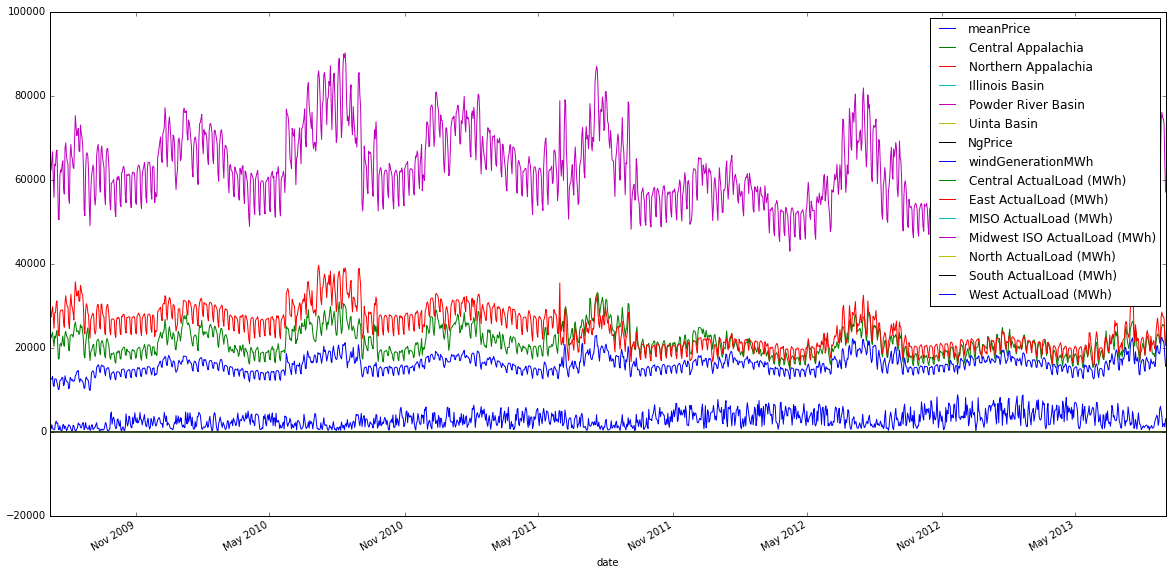

In [79]:
df = pd.merge(dfY, dfX, left_index=True, right_index=True, how='inner')
df = df[:'2013-09-01']
df.plot()

## Ridge Regression

In [157]:
#Train
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 5e0, 1e1, 5e1, 1e2, 5e2, 1e3])
fit = ridge.fit(df.drop('meanPrice', axis=1), df['meanPrice'])

print 'Alpha: ', ridge.alpha_
print 'Score: ', fit.score(df.drop('meanPrice', axis=1), df['meanPrice'])

Alpha:  100.0
Score:  0.0220083834651


In [158]:
# Regression Coefficients
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Predictors,Coefficients
5,NgPrice,1.927146
1,Northern Appalachia,0.192937
2,Illinois Basin,0.092745
7,Central ActualLoad (MWh),0.000298
8,East ActualLoad (MWh),0.000200
10,Midwest ISO ActualLoad (MWh),0.000042
9,MISO ActualLoad (MWh),0.000000
11,North ActualLoad (MWh),0.000000
12,South ActualLoad (MWh),0.000000
6,windGenerationMWh,-0.000092


## LASSO Regression

In [159]:
# Train
ridge = linear_model.LassoCV(alphas=[5e2, 1e3, 2e3, 3e3, 4e3, 5e3, 1e4])
fit = ridge.fit(df.drop('meanPrice', axis=1), df['meanPrice'])

print 'Alpha: ', ridge.alpha_
print 'Score: ', fit.score(df.drop('meanPrice', axis=1), df['meanPrice'])

Alpha:  2000.0
Score:  0.0118445565974


In [160]:
# Regression Coefficients
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Predictors,Coefficients
10,Midwest ISO ActualLoad (MWh),0.000178
0,Central Appalachia,0.000000
1,Northern Appalachia,0.000000
2,Illinois Basin,0.000000
3,Powder River Basin,0.000000
4,Uinta Basin,0.000000
5,NgPrice,0.000000
6,windGenerationMWh,-0.000000
7,Central ActualLoad (MWh),0.000000
8,East ActualLoad (MWh),0.000000
